In [4]:
from livablestreets.utils import get_file
df_grid = get_file(file_name='FeatCount_berlin_grid_1000m.csv', local_file_path=f'/livablestreets/data/berlin/WorkingTables')
df_grid.describe()

===> Loaded FeatCount_berlin_grid_1000m.csv locally


,lat_start,lat_end,lng_start,lng_end,lat_center,lng_center,km_to_centroid,degrees_to_centroid,comfort_leisure_spots,activities_education,...,activities_health_local,comfort_green_space,comfort_rivers,negative_warehouse,negative_retail,activities_post,negative_railway,negative_industrial,comfort_green_parks,negative_supermarket
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,...,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,52.500245,52.509245,13.413647,13.428433,52.504745,13.421040,15.776512,177.454497,0.436637,0.084685,...,0.785586,11.093694,0.564565,0.757958,7.902703,0.787387,4.628829,6.557357,34.148348,0.385586
std,0.096123,0.096123,0.192092,0.192092,0.096123,0.192092,5.998542,113.092300,1.402171,0.413896,...,2.769213,28.185910,2.882235,8.390179,24.276555,1.535387,18.679621,32.552369,92.732194,2.973082
min,52.338245,52.347245,13.088345,13.103131,52.342745,13.095738,0.449114,0.541420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.419245,52.428245,13.250996,13.265782,52.423745,13.258389,11.536915,71.889798,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.500245,52.509245,13.413647,13.428433,52.504745,13.421040,16.304442,176.985620,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.581245,52.590245,13.576298,13.591084,52.585745,13.583691,20.262206,276.855671,0.000000,0.000000,...,0.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,34.000000,0.000000
max,52.662245,52.671245,13.738949,13.753735,52.666745,13.746342,29.628935,359.042618,15.000000,5.000000,...,57.000000,361.000000,41.000000,294.000000,307.000000,11.000000,217.000000,659.000000,2031.000000,58.000000


In [24]:
def convert_feature_impact(df, column, stepsize = 200):

    ################### Activities ######################
    if column == 'activities_economic':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_education':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_educational':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_goverment':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_health_local':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_health_regional':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_post':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'activities_public_service':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}

    ################### Comfort ######################
    if column == 'comfort_comfort_spots':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_green_forests':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_green_natural':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_green_parks':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_green_space':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_lakes':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_leisure_mass':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_leisure_spots':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'comfort_rivers':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}

    ################### Mobility ######################
    if column == 'mobility_bike_infraestructure':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'mobility_public_transport_bus':
        converstion_dict = {0:-1, 1:1, 2:2, 3:4, 4:2, 5:1,
                            6:0, 7:-1, 8:-2, 9:-4}
    if column == 'mobility_public_transport_rail':
        converstion_dict = {0:0, 1:1, 2:2, 3:1, 4:0, 5:-1, 6:-2}

    ################### Negative ######################
    if column == 'negative_industrial':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_railway':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_retail':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_street_motorway':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_street_primary':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_street_secondary':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_supermarket':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'negative_warehouse':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}

    ################### Social life ######################
    if column == 'social_life_community':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'social_life_culture':
        converstion_dict = {0:1, 1:2, 2:4, 3:8, 5:4, 6:2,
                            7:1, 8:-1, 9:-2, 10:-4}
    if column == 'social_life_eating':
        x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        y = [-1, 0, 1, 2, 3, 2, 1, 1, 0, -1, -2]
        degree = 6
    if column == 'social_life_night_life':
        x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        y = [0, 1, 3, 2, 1, 0, -1, -2, -3, -4, -4]
        degree = 3

    model = np.polyfit(x, y, degree)
    predict = np.poly1d(model)

    converted_values = [val / int(stepsize/100) for val in list(df[column])] # Divide by stepsize/100 to unify measurement over a 100 meters area
    converted_values = [y[0] if value <= x[0] else y[-1] if value >= x[-1] else predict(value) for value in converted_values]

    return converted_values


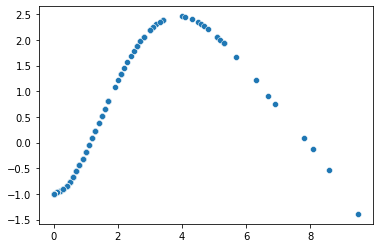

In [25]:
import seaborn as sns
sns.scatterplot(x=[val/10 for val in list(df_grid['social_life_eating'])], y=convert_feature_impact(df_grid, 'social_life_eating', stepsize = 1000));

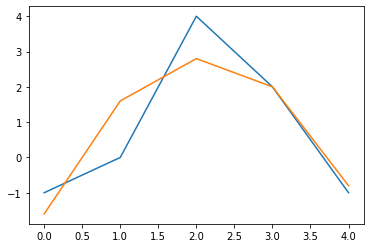

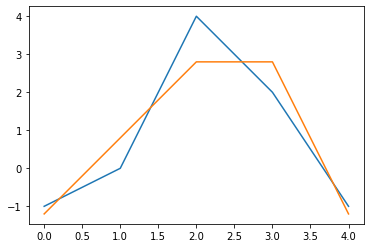

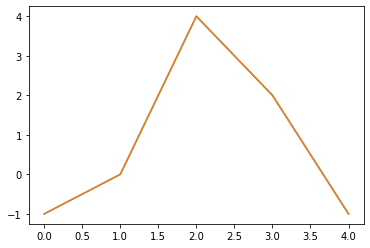

/home/carlo/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


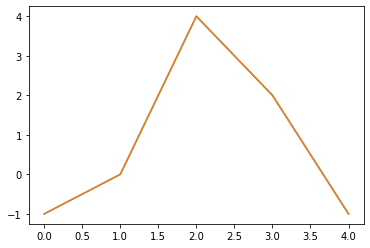

/home/carlo/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


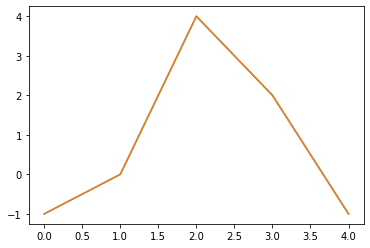

/home/carlo/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


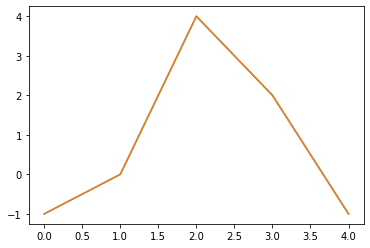

/home/carlo/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


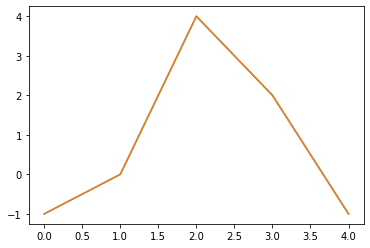

In [8]:
import numpy as np
from matplotlib import pyplot as plt

x = [0, 1, 2, 3, 4]
y = [-1, 0, 4, 2, -1]


for degree in range(2,9):
    model = np.polyfit(x, y, degree)
    predict = np.poly1d(model)
    plt.plot(x, y)
    plt.plot(x, predict(x))
    plt.show()

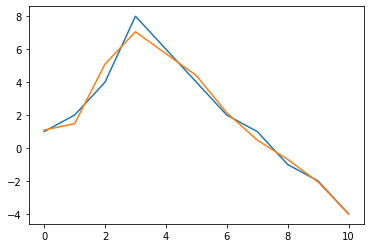

array([ 0.34808632,  5.54443663,  7.05776415,  2.13947696, -0.68713478,
       -5.0001779 ])

In [34]:
model = np.polyfit(x, y, 6)
predict = np.poly1d(model)
plt.plot(x, y)
plt.plot(x, predict(x))
plt.show()
hours_studied = [0.5,4.5,3,6,8]
predict(hours_studied)